In [4]:
import pickle, gzip, math, os, time, shutil, torch, matplotlib.pyplot as plt, numpy as np

In [5]:
import pandas as pd
import pathlib as Path
from torch.utils.data import DataLoader, default_collate
from typing import Mapping 

In [6]:
import datasets

/opt/anaconda3/envs/cv_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
with gzip.open('data/mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [8]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

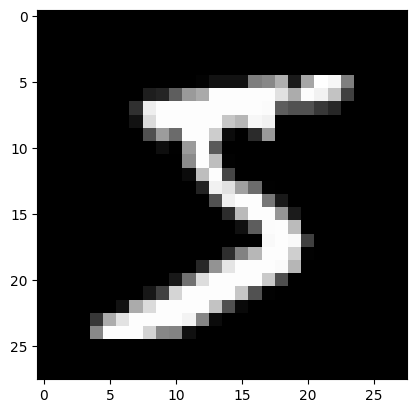

In [9]:
plt.imshow(x_train[0].view(28,28), cmap='gray')

In [10]:
sample_kernel = torch.randn(3, 3)
sample_kernel

tensor([[-0.7751, -0.3177, -1.1555],
        [ 1.5750,  2.7337,  0.0122],
        [ 0.6855, -1.2304, -1.3916]])

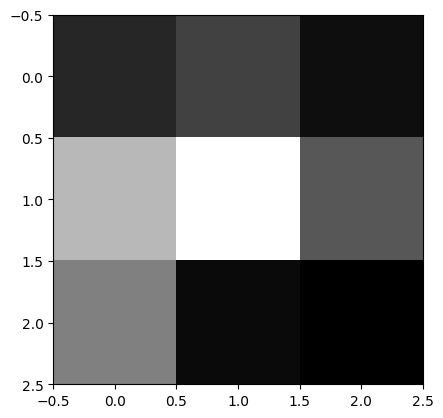

In [11]:
plt.imshow(sample_kernel, cmap='gray')

During training, we slide such kernels with learnable parameters across the input image, thereby capturing different aspects of the image.

In [12]:
def apply_kernel(x, row, col, kernel):
    return (x[row:row+kernel.shape[0], col:col+kernel.shape[1]] * kernel).sum()

In [13]:
x_train.shape

torch.Size([50000, 784])

In [14]:
x_train = x_train.view(x_train.shape[0], 28, 28)
x_train.shape

torch.Size([50000, 28, 28])

In [15]:
apply_kernel(x_train[0], 5, 5, sample_kernel)

tensor(-0.2664)

torch.Size([26, 26])


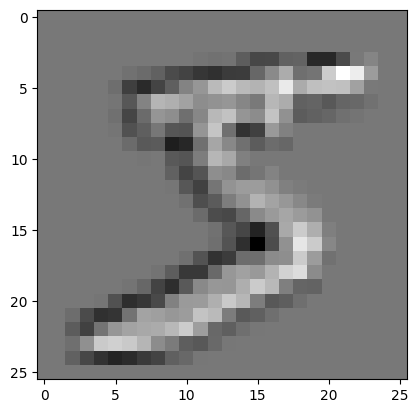

In [16]:
conv_output = torch.tensor([[apply_kernel(x_train[0], i, j, sample_kernel) for j in range(26)] for i in range(26)])
print(conv_output.shape)
plt.imshow(conv_output, cmap='gray')

The above is the output of the convolution operation on the original image. Our output is reduced to 26x26 from 28x28 due to the kernel size of 3x3. If we increase the kernel size, the output size will decrease.

Padding allows us to avoid this downsizing/data loss

## Im2Col

The reason we can do fast convolutions on GPUs, is because we can leverage "im2col" which essentially represents convolutions as matrix multiplications. 

The TL;DR is that we unroll portion of the image corresponding to the kernel size, and then perform matrix multiplication with the kernel. This is done for all patches in the image, and then we get our final output.

# 
# ![im2col](im2col.png)
# 




the torch implementation of the above is F.unfold and of convolutions is F.conv2d

In [21]:
from torch import nn 

simple_cnn = nn.Sequential(
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),    # 14x14x4
    nn.ReLU(),
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),    # 7x7x8
    nn.ReLU(),
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),    # 4x4x16
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),    # 2x2x16
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),    # 1x1x10
    nn.Flatten(),
)

In [22]:
simple_cnn(x_train[:1])

tensor([[-0.0551],
        [ 0.0507],
        [-0.0497],
        [-0.0340],
        [ 0.0843],
        [ 0.1052],
        [-0.0686],
        [ 0.0595],
        [-0.0868],
        [ 0.0147]], grad_fn=<ViewBackward0>)

In [23]:
simple_cnn

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (9): Flatten(start_dim=1, end_dim=-1)
)